In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from xgboost import XGBClassifier

import shap

In [2]:
df = pd.read_csv('../dataset/mushrooms.csv')

In [3]:
df

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,p,x,s,n,t,p,f,c,n,k,...,s,w,w,p,w,o,p,k,s,u
1,e,x,s,y,t,a,f,c,b,k,...,s,w,w,p,w,o,p,n,n,g
2,e,b,s,w,t,l,f,c,b,n,...,s,w,w,p,w,o,p,n,n,m
3,p,x,y,w,t,p,f,c,n,n,...,s,w,w,p,w,o,p,k,s,u
4,e,x,s,g,f,n,f,w,b,k,...,s,w,w,p,w,o,e,n,a,g
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8119,e,k,s,n,f,n,a,c,b,y,...,s,o,o,p,o,o,p,b,c,l
8120,e,x,s,n,f,n,a,c,b,y,...,s,o,o,p,n,o,p,b,v,l
8121,e,f,s,n,f,n,a,c,b,n,...,s,o,o,p,o,o,p,b,c,l
8122,p,k,y,n,f,y,f,c,n,b,...,k,w,w,p,w,o,e,w,v,l


In [4]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

df_encoded = df.copy()

for column in df.select_dtypes('object'):
    df_encoded[column] = LabelEncoder().fit_transform(df_encoded[column])

y = df_encoded['class']
y = y.astype('category').cat.codes
X = df_encoded.drop('class', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [5]:
def evaluate(y_real, y_pred):
    if isinstance(list(y_pred)[0], (int, np.int32, np.int64)):
        from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
        
        acc = accuracy_score(y_real, y_pred)
        prc = precision_score(y_real, y_pred)
        rec = recall_score(y_real, y_pred)
        f1 = f1_score(y_real, y_pred)
        
        return pd.Series([acc, prc, rec, f1], index=['Accuracy', 'Precision', 'Recall', 'F1'])
    
    else:
        from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
        from scipy.stats import pearsonr
        
        mae = mean_absolute_error(y_real, y_pred)
        rmse = np.sqrt(mean_squared_error(y_real, y_pred))
        r2 = r2_score(y_real, y_pred)
        corr, _ = pearsonr(y_real, y_pred)
        
        return pd.Series([mae, rmse, r2, corr], index=['MAE', 'RMSE', 'R2', 'PearsonR'])

In [6]:
model = XGBClassifier().fit(X_train, y_train)
pred = model.predict(X_test)

evaluate(y_test, pred)

Accuracy     1.0
Precision    1.0
Recall       1.0
F1           1.0
dtype: float64

In [7]:
explainer = shap.TreeExplainer(model)
shap_values = explainer(X_test)

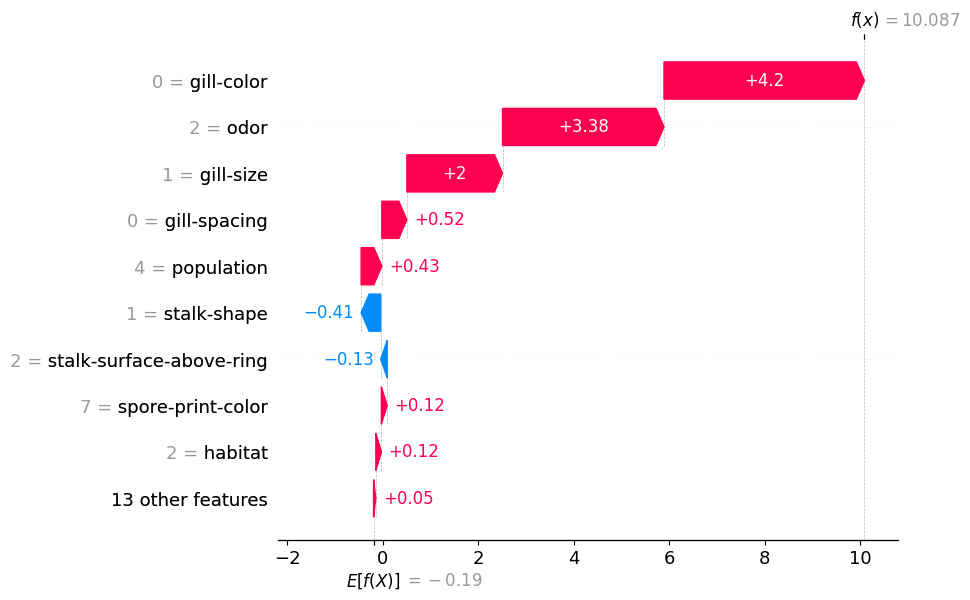

In [8]:
idx = 17
want_to_show = shap_values[idx]
shap.plots.waterfall(want_to_show)

In [9]:
want_to_show

.values =
array([-0.03574339,  0.08915079, -0.09240165, -0.03770014,  3.381422  ,
        0.        ,  0.5242075 ,  2.0031157 ,  4.1964846 , -0.4103174 ,
        0.03898884, -0.13483137, -0.02827575,  0.0160651 ,  0.07487583,
        0.        ,  0.        , -0.05636278,  0.07896119,  0.12172446,
        0.43303972,  0.11536362], dtype=float32)

.base_values =
-0.1903561

.data =
array([3, 3, 2, 0, 2, 1, 0, 1, 0, 1, 0, 2, 2, 7, 6, 0, 2, 1, 0, 7, 4, 2])

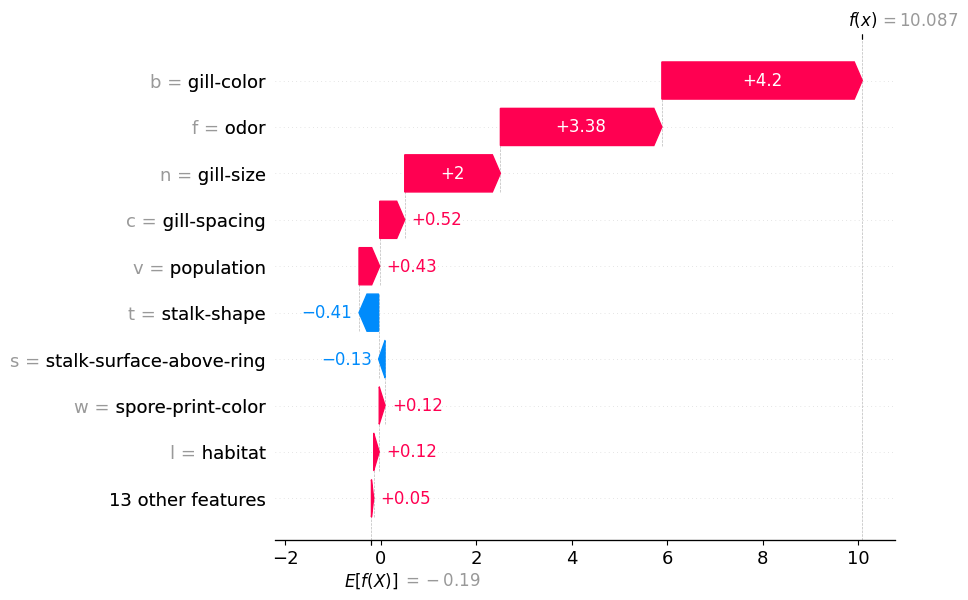

In [10]:
want_to_show.data = df.drop(columns='class').loc[X_test.iloc[idx].name].to_numpy()
shap.plots.waterfall(want_to_show)